<Figure size 1000x600 with 0 Axes>

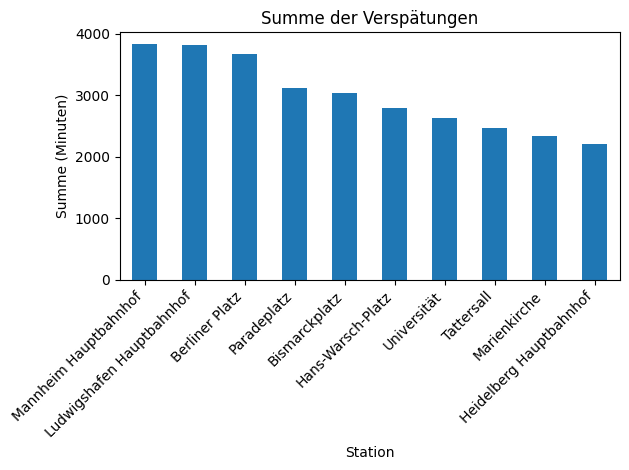

Station: 2417 (Mannheim Hauptbahnhof, Mannheim), Summe der Zeitunterschiede = 3829.85 Minuten
Station: 2080 (Ludwigshafen Hauptbahnhof, Ludwigshafen), Summe der Zeitunterschiede = 3820.82 Minuten
Station: 2066 (Berliner Platz, Ludwigshafen), Summe der Zeitunterschiede = 3667.22 Minuten
Station: 2451 (Paradeplatz, Mannheim), Summe der Zeitunterschiede = 3114.27 Minuten
Station: 1146 (Bismarckplatz, Heidelberg), Summe der Zeitunterschiede = 3039.33 Minuten
Station: 2154 (Hans-Warsch-Platz, Ludwigshafen), Summe der Zeitunterschiede = 2787.37 Minuten
Station: 2471 (Universität, Mannheim), Summe der Zeitunterschiede = 2625.38 Minuten
Station: 2466 (Tattersall, Mannheim), Summe der Zeitunterschiede = 2469.28 Minuten
Station: 2090 (Marienkirche, Ludwigshafen), Summe der Zeitunterschiede = 2337.75 Minuten
Station: 1160 (Heidelberg Hauptbahnhof, Heidelberg), Summe der Zeitunterschiede = 2212.17 Minuten
Station: 2462 (Schloss, Mannheim), Summe der Zeitunterschiede = 2109.45 Minuten
Station: 2086

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pymysql

db = pymysql.connect(host="localhost", user="rnv_importer", password="rnv_importer", database="rnv_big_data_mining")
cursor = db.cursor()

cursor.execute("SELECT api_plannedDeparture, api_realtimeDeparture, api_station, api_longName, api_place from stations inner join stops On api_plannedDeparture != api_realtimeDeparture where stations.api_hafasID = stops.api_station;")
latencies = cursor.fetchall()

sorted_latencies = sorted(latencies, key=lambda x: x[2])

station_sums = {}
for latency in sorted_latencies:
    planned_departure = pd.to_datetime(latency[0])
    realtime_departure = pd.to_datetime(latency[1])
    station_id = latency[2]

    time_difference = (realtime_departure - planned_departure).total_seconds()

    if station_id in station_sums:
        station_sums[station_id] += time_difference
    else:
        station_sums[station_id] = time_difference

station_sums = dict(sorted(station_sums.items(), key=lambda item: item[1], reverse=True))
df = pd.DataFrame(list(station_sums.items()), columns=['Station', 'Summe der Verspätungen'])
df['Station'] = [next((x[3] for x in sorted_latencies if x[2] == station_id), None) for station_id in df['Station']]
df['Summe der Verspätungen'] /= 60

plt.figure(figsize=(10, 6))  # Anpassen der Größe des Diagramms
ax = df.head(10).plot(kind="bar", x='Station', y='Summe der Verspätungen', rot=45, align='center', legend=False)  # Rotieren und zentrieren
plt.xlabel('Station')
plt.ylabel('Summe (Minuten)')
plt.title('Summe der Verspätungen')
plt.xticks(rotation=45, ha='right')  # Rotieren und rechtsbündig ausrichten
plt.tight_layout()  # Verbesserung des Layouts
plt.show()

for station_id, time_sum in list(station_sums.items()):
    # Finde den api_longName und api_place für die aktuelle Station
    long_name, place = next(((x[3], x[4]) for x in sorted_latencies if x[2] == station_id), (None, None))

    # Umrechne von Sekunden zu Minuten
    time_sum_minutes = time_sum / 60

    print(f"Station: {station_id} ({long_name}, {place}), Summe der Zeitunterschiede = {time_sum_minutes:.2f} Minuten")

<Figure size 1000x600 with 0 Axes>

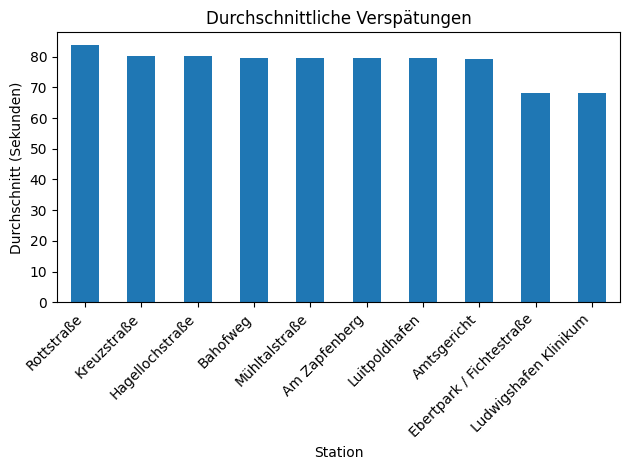

Station: 2101 (Rottstraße, Ludwigshafen), Summe der Zeitunterschiede = 83.73 Sekunden
Station: 2030 (Kreuzstraße, Ludwigshafen), Summe der Zeitunterschiede = 80.21 Sekunden
Station: 2032 (Hagellochstraße, Ludwigshafen), Summe der Zeitunterschiede = 80.21 Sekunden
Station: 6410 (Bahofweg, Heidelberg), Summe der Zeitunterschiede = 79.67 Sekunden
Station: 6411 (Mühltalstraße, Heidelberg), Summe der Zeitunterschiede = 79.67 Sekunden
Station: 6825 (Am Zapfenberg, Heidelberg), Summe der Zeitunterschiede = 79.67 Sekunden
Station: 2114 (Luitpoldhafen, Ludwigshafen), Summe der Zeitunterschiede = 79.54 Sekunden
Station: 2113 (Amtsgericht, Ludwigshafen), Summe der Zeitunterschiede = 79.38 Sekunden
Station: 2029 (Ebertpark / Fichtestraße, Ludwigshafen), Summe der Zeitunterschiede = 68.19 Sekunden
Station: 2079 (Ludwigshafen Klinikum, Ludwigshafen), Summe der Zeitunterschiede = 68.19 Sekunden
Station: 2112 (Heinrich-Ries-Halle, Ludwigshafen), Summe der Zeitunterschiede = 68.19 Sekunden
Station: 204

In [2]:
station_sums_copy = station_sums.copy()

# Berechne Durchschnittsverspätungen in Sekunden
for station_id, time_sum in list(station_sums_copy.items()):
    cursor.execute("SELECT Count(*) from stops where api_station = %s;", station_id)
    totalstops = cursor.fetchone()
    station_sums_copy[station_id] /= totalstops[0]

# Sortiere das aktualisierte station_sums_copy nach der durchschnittlichen Verspätung
station_sums_copy = dict(sorted(station_sums_copy.items(), key=lambda item: item[1], reverse=True))

# Erstelle ein DataFrame für das zweite Diagramm
dfa = pd.DataFrame(list(station_sums_copy.items()), columns=['Station', 'Durchschnittliche Verspätungen'])
dfa['Station'] = [next((x[3] for x in sorted_latencies if x[2] == station_id), f"Unknown_{station_id}") for station_id in dfa['Station']]

# Plot the data für das zweite Diagramm
plt.figure(figsize=(10, 6))
ax = dfa.head(10).plot(kind="bar", x='Station', y='Durchschnittliche Verspätungen', rot=45, align='center', legend=False)
plt.xlabel('Station')
plt.ylabel('Durchschnitt (Sekunden)')  # Ändere die Achsenbeschriftung
plt.title('Durchschnittliche Verspätungen')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Ausgabe der Zeitunterschiede in Sekunden
for station_id, time_sum in list(station_sums_copy.items()):
    # Finde den api_longName und api_place für die aktuelle Station
    long_name, place = next(((x[3], x[4]) for x in sorted_latencies if x[2] == station_id), (None, None))

    # Ausgabe der Zeitunterschiede in Sekunden
    print(f"Station: {station_id} ({long_name}, {place}), Summe der Zeitunterschiede = {time_sum:.2f} Sekunden")